<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_6%5DWriting_lyrics(NLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Exp_6]Writing_lyrics(NLP)

## 1. 라이브러리 버전 확인 및 import

In [1]:
import tensorflow as tf
import glob
import re
import numpy as np
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import GridSearchCV, train_test_split


print(tf.__version__)

2.8.2


## 2. 데이터 읽어오기

In [2]:
txt_file_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/lyrics/*"

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus에 담는다.
for txt_file in txt_list:
  with open(txt_file, "r") as f:
    raw = f.read().splitlines()
    raw_corpus.extend(raw)

print('데이터 크기 : ', len(raw_corpus))
print('Examples : \n', raw_corpus[:3])

데이터 크기 :  227088
Examples : 
 ['The first words that come out', 'And I can see this song will be about you', "I can't believe that I can breathe without you"]


## 3. 데이터 정제

### 1) 정규표현식 사용

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1 소문자로 바꾸고, 양쪽 공백을 지운다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2 특수문자 양쪽에 공백을 넣는다.
    sentence = re.sub(r'[" "]+', " ", sentence) # 3 여러개의 공백은 하나의 공백으로 바꾼다.
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4 a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾼다. 
    sentence = sentence.strip() # 5 다시 양쪽 공백을 지운다.
    sentence = '<start> ' + sentence + ' <end>' # 6 START와 END를 추가해준다.
    return sentence


### 2) 불필요한 문자 제외 및 corpus에 담기

In [4]:
corpus = []

for sentence in raw_corpus:
  if len(sentence) == 0: continue
  if sentence[-1] == ":": continue # 데이터를 확인해본결과 셰익스피어 파일도 있기 때문에 이것도 넣어 주었다.
  
  preprocessed_sentence = preprocess_sentence(sentence)
  corpus.append(preprocessed_sentence)
        

corpus[:20]

['<start> the first words that come out <end>',
 '<start> and i can see this song will be about you <end>',
 '<start> i can t believe that i can breathe without you <end>',
 '<start> but all i need to do is carry on <end>',
 '<start> the next line i write down <end>',
 '<start> and there s a tear that falls between the pages <end>',
 '<start> i know that pain s supposed to heal in stages <end>',
 '<start> but it depends which one i m standing on i write lines down , then rip them up <end>',
 '<start> describing love can t be this tough i could set this song on fire , send it up in smoke <end>',
 '<start> i could throw it in the river and watch it sink in slowly <end>',
 '<start> tie the pages to a plane and send it to the moon <end>',
 '<start> play it for the world , but it won t mean much <end>',
 '<start> unless i sing this song to you i m dying to show you <end>',
 '<start> this could end happily ever after <end>',
 '<start> there doesn t ever have to be disaster <end>',
 '<start> 

- 노래 가사 데이터이기 때문에 "if sentence[-1] == ":": continue" 이 코드는 제거 하였으나 데이터를 다시 확인해보니 셰익스피어 대본이 들어가 있어 다시 이 코드를 추가하여 학습을 진행하였다. 

### 3) 토큰화
- 정규표현식으로 필터링 했기 때문에 여기에서 filters에는 아무것도 넣지 않았다.

In [5]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    tokenizer.fit_on_texts(corpus) # 내부 단어장 만들기
    tensor = tokenizer.texts_to_sequences(corpus) # Tensor로 변환   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=21) # 시퀀스 길이, 패딩길이, 패딩 위치 지정
    print(tensor,tokenizer)
    
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2    6  237 ...    0    0    0]
 [   2    8    5 ...    0    0    0]
 [   2    5   38 ...    0    0    0]
 ...
 [   2  848    1 ...    0    0    0]
 [   2  161   64 ...    0    0    0]
 [   2 4396  161 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fc25dccdb50>


- maxlen 지정하기
  - LMS에서 15개 단어로 문장을 잘라주는 것을 권장하여 paading을 maxlen=16을 해주어 start 혹은 end를 뺐을때 15개가 남도록 해주었다. 
  - 그러나 이렇게 해서는 아무리 해도 val_loss가 2.2밑으로 떨어지지가 않았다. 최소가 2.2017이었다. 
  - 그래서 어차피 최종은 길이가 20인 문장을 추출하니까 거기에 맞춰서 maxlen을 21로 지정하여 길이가 20문장 아래은 데이터로 학습을 하였다.
    - 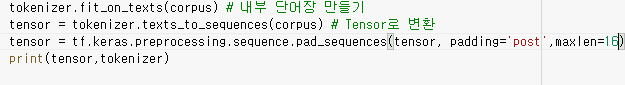

- 참고자료
 - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
  - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

- tf.keras.utils.pad_sequences
  - 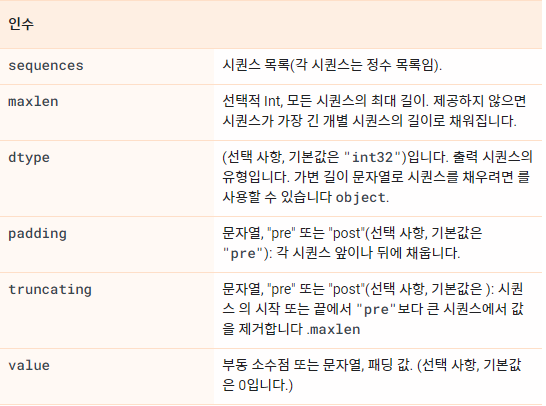

- tf.keras.preprocessing.text.Tokenizer
  - 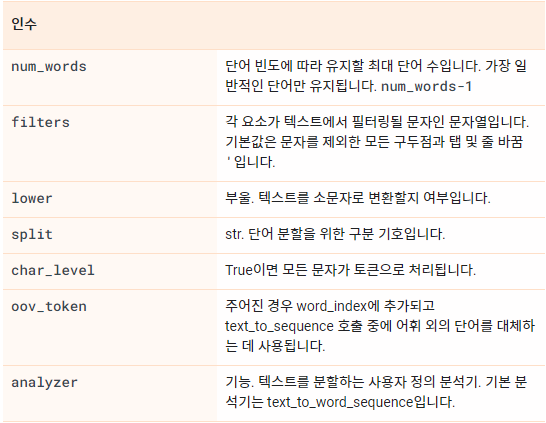

In [6]:
print(tensor)

[[   2    6  237 ...    0    0    0]
 [   2    8    5 ...    0    0    0]
 [   2    5   38 ...    0    0    0]
 ...
 [   2  848    1 ...    0    0    0]
 [   2  161   64 ...    0    0    0]
 [   2 4396  161 ...    0    0    0]]


In [7]:
# 너무 길어서 git에서는 지저분해지기 때문에 생략
# print(index_word_sorted)

## 4. 평가 데이터셋 분리

- LMS상에서 권장한 dataset 객체화를 train_dataset, test_dataset으로 하였으나 오히려 val_loss가 오른 것을 확인하였었다. 물론 다른 여러 경우의 수를 가정해야하지만 maxlen=15로 지정하였을 위와 같이 성능이 역행하였다.
- 내가 잘 못 적용하였는지 추후 다른 그루들과 이 프로젝트 기간이 끝나고 코드를 소통해봐야 겠다.

  - 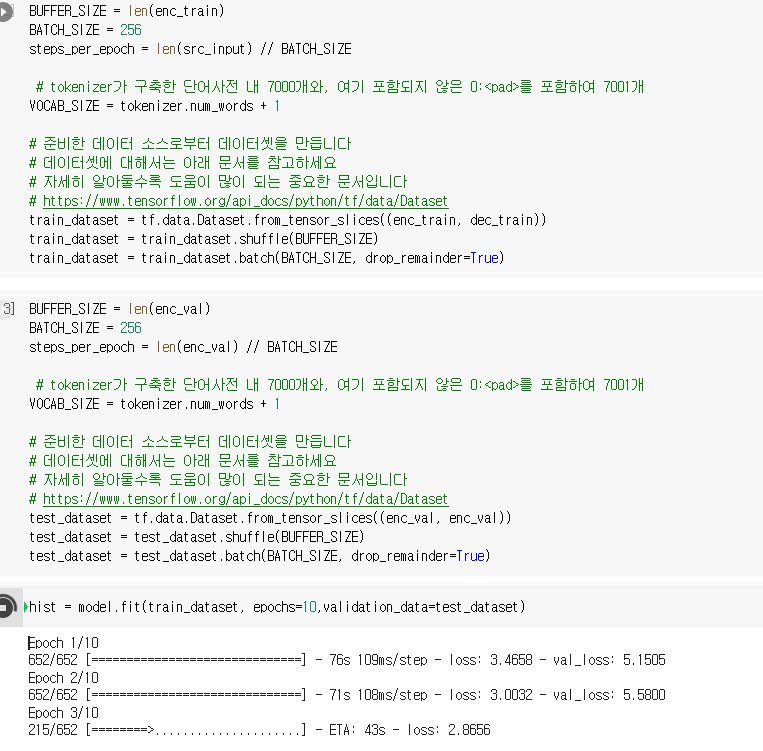

### 1) target, feature 분리

In [8]:
src_input = tensor[:, :-1]  
tgt_input = tensor[:, 1:]    

print(src_input[1])
print(tgt_input[1])

[  2   8   5  38  69  34 372  77  27 122   7   3   0   0   0   0   0   0
   0   0]
[  8   5  38  69  34 372  77  27 122   7   3   0   0   0   0   0   0   0
   0   0]


### 2) train과 val분리 분리

In [9]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=23 )

## 5.인공지능 만들기

### 1) TextGenerator 클래스 생성

In [10]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 512
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

- val_loss가 떨어지지 않아 파라미터 값을 높였으나 2.2017이 한계였다. 그래서 maxlen을 조정해주고 다시 파라미터값을 하향 조정하였다.
  - 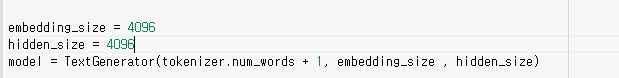

### 2) optimizer, loss 및 model compile

In [11]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)

### 3) 모델 학습

In [12]:
hist = model.fit(enc_train, dec_train, epochs=10,validation_data=(enc_val, dec_val),batch_size=128)

Epoch 1/10
1249/1249 [==============================] - 112s 85ms/step - loss: 2.6086 - val_loss: 2.3734
Epoch 2/10
1249/1249 [==============================] - 105s 84ms/step - loss: 2.2782 - val_loss: 2.2228
Epoch 3/10
1249/1249 [==============================] - 105s 84ms/step - loss: 2.1315 - val_loss: 2.1333
Epoch 4/10
1249/1249 [==============================] - 105s 84ms/step - loss: 2.0149 - val_loss: 2.0738
Epoch 5/10
1249/1249 [==============================] - 105s 84ms/step - loss: 1.9111 - val_loss: 2.0280
Epoch 6/10
1249/1249 [==============================] - 105s 84ms/step - loss: 1.8153 - val_loss: 1.9989
Epoch 7/10
1249/1249 [==============================] - 105s 84ms/step - loss: 1.7264 - val_loss: 1.9826
Epoch 8/10
1249/1249 [==============================] - 105s 84ms/step - loss: 1.6451 - val_loss: 1.9691
Epoch 9/10
1249/1249 [==============================] - 105s 84ms/step - loss: 1.5691 - val_loss: 1.9641
Epoch 10/10
1249/1249 [==============================] 

### 4) 모델 검증 그래프

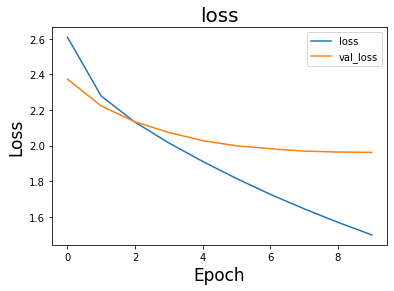

In [13]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('loss',fontsize=20)
plt.xlabel('Epoch', fontsize=17)
plt.ylabel('Loss',fontsize=17)
plt.legend(['loss', 'val_loss'], loc='upper right')

plt.show()

## 6. 결과 확인

### 1) generate_text 함수 생성

In [14]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만든다.
    while True:
        # 1입력받은 문장의 텐서를 입력한다.
        predict = model(test_tensor) 
        
        # 2 예측된 값 중 가장 높은 확률인 word index를 뽑아낸다.
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
       
        # 3 2에서 예측된 word index를 문장 뒤에 붙입니다
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        
        # 4모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마친ㄷ.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환한다.
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

### 2) 결과 도출

In [15]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you so much , i love you so much <end> '

## 회고

- 시도해본 것
  - LMS에 있는 데이터셋 객체를 생성하는 코드를 적용하여 train_dataset과 test_dataset을 만들어서 학습을 시켰으나 val_loss가 5점대로 올라갔고 학습을 할때마다 더 올라간 것을 확인할 수 있었다
  - 음악 가사 이기 때문에 LMS에 있는  if sentence[-1] == ":": continue 코드를 지우고 사용하였지만 이번 데이터셋에도 셰익스피어 파일이 있는 것을 확인하여 다시 이 코드를 적용시켰다.
  - 문장 길이를 15개로 권장하여서 15개로 계속 시도해보았으니 val_loss가 2.2017이 최솟값이고 더이상 떨어지지 않는 것을 확인할 수 있었다. 그래서 어차피 마지막에 길이가 20인 문장을 출력하고 있으니 paading에서 maxlen을 21로 지정하여 20개의 문장으로 학습을 진행하였다.
  - embedding_size와 hidden_size를 4096까지 올려 val_loss를 낮추려고 시도해보았으나 2.2017이 최소이며 사용하는 문장길이를 21로 늘려주니 금방 val_loss를 맞출 수 있었다. 그래서 LMS상인 embedding_size = 256, hidden_size=1024로 맞추어서 다시 학습을 진행하였다.
  - batch_size를 조정하여 데이터를 나누어주어 학습 속도를 올릴 수 있었다.

- 아쉬운 점
  - 여러가지를 시도해 본 것 같지만 코드에 남는건 별로 없는듯 하다.
  - 여기에서 무엇을 더 추가로 공부해 적용할 수 있을지 잘 모르겠다.